### Brief data analysis 

In [2]:
import pandas as pd
import tensorflow as tf
import json
from pandas.core.frame import DataFrame

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils.np_utils import to_categorical


C:\Users\qiuji\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import tensorflow as tf
tf.__version__


'2.10.0'

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.debugging.set_log_device_placement(True)

In [27]:
df = pd.read_json("train_data.json",encoding="utf-8", orient='records')
df

,text,id,relation_list,entity_list
0,Massachusetts ASTON MAGNA Great Barrington ; a...,train_0,"[{'subject': 'Annandale-on-Hudson', 'object': ...","[{'text': 'Annandale-on-Hudson', 'type': 'DEFA..."
1,North Carolina EASTERN MUSIC FESTIVAL Greensbo...,train_1,"[{'subject': 'North Carolina', 'object': 'Gree...","[{'text': 'North Carolina', 'type': 'DEFAULT',..."
2,It will be the final movie credited to Debra H...,train_2,"[{'subject': 'Debra Hill', 'object': 'Haddonfi...","[{'text': 'Debra Hill', 'type': 'DEFAULT', 'ch..."
3,In a 3-0 victory over the Crew on Saturday in ...,train_3,"[{'subject': 'Ohio', 'object': 'Columbus', 'su...","[{'text': 'Ohio', 'type': 'DEFAULT', 'char_spa..."
4,"The United States ambassador to Mexico , Tony ...",train_4,"[{'subject': 'Mexico', 'object': 'Nuevo Laredo...","[{'text': 'Mexico', 'type': 'DEFAULT', 'char_s..."
...,...,...,...,...
56191,"Tanna 's big draw is Mount Yasur , one of the ...",train_56191,"[{'subject': 'Tanna', 'object': 'Mount Yasur',...","[{'text': 'Tanna', 'type': 'DEFAULT', 'char_sp..."
56192,We flew Air Pacific -LRB- 800-227-4446 ; www.a...,train_56192,"[{'subject': 'Vanuatu', 'object': 'Port Vila',...","[{'text': 'Vanuatu', 'type': 'DEFAULT', 'char_..."
56193,"I think Westchester is changing , '' said Kenn...",train_56193,"[{'subject': 'Kenneth T. Jackson', 'object': '...","[{'text': 'Kenneth T. Jackson', 'type': 'DEFAU..."
56194,Here we have a 172-acre island with four-star ...,train_56194,"[{'subject': 'Ellis Island', 'object': 'Manhat...","[{'text': 'Ellis Island', 'type': 'DEFAULT', '..."


### Data preprocess

In [15]:
def data_process(train_file,valid_file,test_file):
    
    #tf.debugging.set_log_device_placement(True)
    df = pd.read_json(train_file,encoding="utf-8", orient='records')
    with open("rel2id.json","r") as f:
        rel2id = json.load(f)
        id2rel = {k:v for k, v in rel2id.items()}
        num_classes = len(rel2id)
        
        
    n_most_common_words = 50000 # vocabulary size
    max_len = 100
# Initialization
    tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['text'].values)
    
    X_train = input_process(tokenizer,df,max_len)
    label_train = label_process(df,id2rel)
    
    df_valid = pd.read_json(valid_file,encoding="utf-8", orient='records')
    X_valid = input_process(tokenizer,df_valid,max_len)
    label_valid = label_process(df_valid,id2rel)
    
    df_test = pd.read_json(test_file,encoding="utf-8", orient='records')
    X_test = input_process(tokenizer,df_test,max_len)
    label_test = label_process(df_test,id2rel)
    

    
    return X_train, label_train, X_valid, label_valid, X_test, label_test 

def input_process(tokenizer,df,max_len):
    sequences = tokenizer.texts_to_sequences(df['text'].values)
    #word_index = tokenizer.word_index
    X = pad_sequences(sequences, maxlen=max_len)
    return X

def label_process(df_object,relate_label):
    label=[df_object["relation_list"][i][0]["predicate"] for i in range(df_object.shape[0])]
    train_label = [relate_label[i] for i in label]
    labels=DataFrame(train_label)
    labels = to_categorical(labels, num_classes=24)
    return labels
    

In [16]:
X_train, y_train, X_validation, y_validation,X_test,y_test = data_process("train_data.json","valid_data.json","test_data.json")

In [17]:
y_train.shape

(56196, 24)

In [18]:
from keras import Sequential
from keras.layers import *
embedding_size = 300
n_most_common_words = 50000
model = Sequential()
model.add(Embedding(n_most_common_words, embedding_size, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(y_train.shape[1], activation='relu'))
model.compile(tf.keras.optimizers.Adam(lr = 0.001),loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          15000000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 24)                6168      
                                                                 
Total params: 15,445,464
Trainable params: 15,445,464
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\qiuji\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [12]:
from tensorflow.python.client import device_lib
print(tf.test.is_built_with_cuda())
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

 
 
print(device_lib.list_local_devices())

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3456487010435987500
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5717884928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 634593262848038861
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [20]:
model.fit(X_train, y_train, epochs=3, batch_size=128, validation_data = (X_validation, y_validation),workers=4)
#model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.2)


Epoch 1/3
440/440 [==============================] - 947s 2s/step - loss: 4.6120 - acc: 0.3881 - val_loss: 1.7004 - val_acc: 0.5272
Epoch 2/3
440/440 [==============================] - 865s 2s/step - loss: 1.6867 - acc: 0.5608 - val_loss: 1.6508 - val_acc: 0.5734
Epoch 3/3
440/440 [==============================] - 425s 966ms/step - loss: 1.3015 - acc: 0.6026 - val_loss: 1.5727 - val_acc: 0.6600


In [21]:
model.history.history["loss"]

[4.6119771003723145, 1.6866519451141357, 1.301505446434021]

In [22]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train_metrics,val_metrics):
    plt.plot(train_history[train_metrics])
    plt.plot(train_history[val_metrics])
    plt.title('Train History')
    plt.ylabel(train_metrics)
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.show()


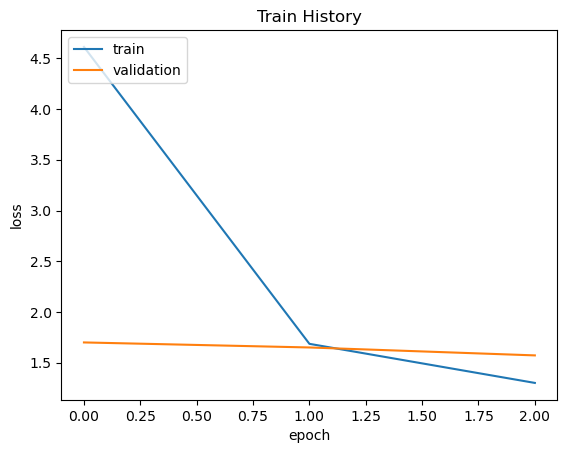

In [23]:
show_train_history(model.history.history,'loss','val_loss')

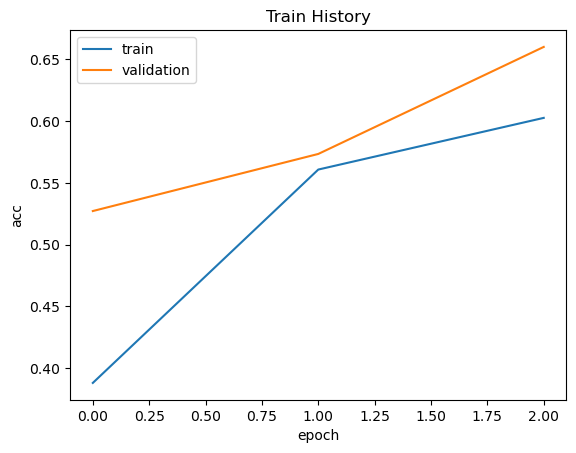

In [25]:
show_train_history(model.history.history,'acc','val_acc')

In [29]:
model.predict(X_test[0])

ValueError: in user code:

    File "C:\Users\qiuji\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\qiuji\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\qiuji\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\qiuji\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\qiuji\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\qiuji\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_1" "                 f"(type Sequential).
    
    Input 0 of layer "bidirectional_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 300)
    
    Call arguments received by layer "sequential_1" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=int32)
      • training=False
      • mask=None


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [33]:
from sklearn.metrics import *
prediction_probas = model.predict(X_test) 


157/157 [==============================] - 12s 74ms/step


In [40]:
predictions[0]

10

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix
predictions = [np.argmax(pred) for pred in prediction_probas]
digit_y = [np.argmax(i)for i in y_test]
print(confusion_matrix(digit_y, predictions)) #from sklearn.metrics
print(classification_report(digit_y, predictions, digits=3))

[[   0    0    0    0    0    1    0    0    0    2    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0   25    0    0    0    3    0    0    0    0
     0    1    0    0    0    0]
 [   0    0    0    0    0    8    0    0    0    4    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    4    0    0    0   25    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0   10    0    0    0    3    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0  291    0    0    0   64    0    0    0    0
     1    4    0    0    0    0]
 [   0    0    0    0    0    1    7    0    0  140    0    0    0    0
     8    0    0    0    0    0]
 [   0    0    0    0    0    0   17    0    0  118    0    0    0    0
     6    1    0    0    0    0]
 [   0    0    0    0    0    3    2    0    0  247    0    0    0    0
    14    2    0    0    0    0]
 [   0    0    0    0    0   27    5    0    0 2496    

C:\Users\qiuji\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiuji\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiuji\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt



In [44]:
text_str=[]
data = confusion_matrix(digit_y, predictions)
for i in range(24):
  x=[]
  for j in range(24):
    x.append(str(data[i][j]))
  text_str.append(x)


ax = sns.heatmap(data, cmap='RdYlGn',vmin=0, vmax=5**3, annot=text_str,fmt="")

xxx = [i for i in range(24)]
xxxs = [str(i) for i in range(24)]
plt.xticks(xxx,xxxs,rotation=45)
plt.yticks(xxx,('0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'),rotation=45)

#We are imagining that the squares in the heat-map are function values corresponding to domain points, [20,40,60,80]x[100,200,300]
plt.title("Heatmap Plot Title")
plt.xlabel("X-axis Labels")
plt.ylabel("Y-axes Labels")


plt.show()


IndexError: index 20 is out of bounds for axis 0 with size 20

In [46]:
data

array([[   0,    0,    0,    0,    0,    1,    0,    0,    0,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,   25,    0,    0,    0,    3,    0,
           0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    8,    0,    0,    0,    4,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    4,    0,    0,    0,   25,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,   10,    0,    0,    0,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,  291,    0,    0,    0,   64,    0,
           0,    0,    0,    1,    4,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,    7,    0,    0,  140,    0,
           0,    0,    0,    8,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    